In [1]:
manta_flavors = ['manta.superEnhanced', 'manta', 'manta.enhanced']
manta_flavors_names = ['less sensitive manta', 'default manta', 'more sensitive manta']    
trfermikit_flavor = 'trfermikit.unitigSupport.thinned'

## trfermikit has better recall-FDR trade-off than manta

In [2]:
import json

def get_confusion_counts(experiment, caller, svtype): 
    with open('{}/truvari-{}-pacbio-{}/summary.txt'.format(experiment, svtype, caller)) as json_file:
        return json.load(json_file)
    
def get_eventCount_callCount(experiment, caller, svtype): 
    try: 
        counts = get_confusion_counts(experiment, caller, svtype)
        event_count = counts['TP-base'] + counts['FN']
        call_count = counts['TP-base'] + counts['FP']
        return event_count, call_count
    except FileNotFoundError: 
        return None, None
    
def get_TPR_FDR(experiment, caller, svtype):
    try: 
        counts = get_confusion_counts(experiment, caller, svtype)
        event_count, call_count = get_eventCount_callCount(experiment, caller, svtype)
        TPR = counts['TP-base']/float(event_count)
        FDR = counts['FP']/float(call_count) 
        return TPR, FDR
    except (FileNotFoundError, ZeroDivisionError): 
        return None, None

def get_config(experiment): 
    with open('{}/config.json'.format(experiment)) as json_file:
        return json.load(json_file)

def get_TPR_FDR_config(experiment, caller, svtype):   
    TPR, FDR = get_TPR_FDR(experiment, caller, svtype)
    config = get_config(experiment)
    return TPR, FDR, config
    
def get_experiments(regions): 
    if regions == 'all': 
        # some experiments correspond to the same trfermikit configuration, e.g. 
        # INS/singleBaseMatchReward_singleBaseMismatchPenalty_gapOpenPenalties_gapExtensionPenalties/data/gapExtensionPenalties=1,0_gapOpenPenalties=6,26_singleBaseMatchReward=10_singleBaseMismatchPenalty=12/config.json
        # optimized_for_DELs/minCoverage_gapOpenPenalties_minUnitigMappingQuality_minUnitigBlockLength/data/minCoverage=0_gapOpenPenalties=6,26_minUnitigMappingQuality=0_minUnitigBlockLength=25/config.json
        # but do not yield the same trfermikit callset, 
        # perhaps because of fermikit's stochasticity: https://github.com/lh3/fermikit#limitations
        experiments = ! ls -d \
            INS/singleBaseMatchReward_singleBaseMismatchPenalty_gapOpenPenalties_gapExtensionPenalties/data/* \
            optimized_for_DELs/minCoverage_gapOpenPenalties_minUnitigMappingQuality_minUnitigBlockLength/data/* 
#             optimized_for_DELs/minSVSize_minRepeatLength_minUnitigBlockLength/data/*
        return experiments
    elif regions == 'intersecting exons and UTRs': 
        experiments = ! ls -d \
            exons_UTRs/singleBaseMatchReward_singleBaseMismatchPenalty_gapOpenPenalties_gapExtensionPenalties/data/* \
            exons_UTRs/minCoverage_gapOpenPenalties_minUnitigMappingQuality_minUnitigBlockLength/data/* 
        return experiments
    elif regions == 'intersecting genes': 
        experiments = ! ls -d \
            genes/singleBaseMatchReward_singleBaseMismatchPenalty_gapOpenPenalties_gapExtensionPenalties/data/* \
            genes/minCoverage_gapOpenPenalties_minUnitigMappingQuality_minUnitigBlockLength/data/* 
        return experiments
    else: 
        print('"{}" is not a valid value for "regions"'.format(regions))
        raise ValueError
             
def get_regions_tag(regions): 
    if regions == 'all': 
        return 'all_regions'
    elif regions == 'intersecting exons and UTRs': 
        return 'regions_intersecting_exons_and_UTRs'
    elif regions == 'intersecting genes': 
        return 'regions_intersecting_genes'
    else: 
        print('"{}" is not a valid value for "regions"'.format(regions))
        raise ValueError
    
def get_TPRs_FDRs_configs(caller, svtype, regions): 
    return tuple(zip(*[get_TPR_FDR_config(experiment, caller, svtype) for experiment in get_experiments(regions)]))


In [3]:
def get_stats(name, counts): 
    return '{} counts: {:.1f} +- {:.1f}'.format(name, np.mean(counts), np.std(counts))

def get_event_call_stats(caller_name, caller, svtype, regions):
    event_counts, call_counts = tuple(zip(*[get_eventCount_callCount(experiment, caller, svtype) for experiment in get_experiments(regions)]))
    return '{}<br>{} {}'.format(get_stats('event', event_counts), caller_name, get_stats('call', call_counts))

In [16]:
# https://stackoverflow.com/a/40239615/6674256 
# this is "is_pareto_efficient_simple"; "is_pareto_efficient_dumb" is buggy
def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) numpy array
    :return: A (n_points, ) numpy boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, cost in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<cost, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def compute_pareto_front(trfermikit_FDRs, trfermikit_TPRs):
    return is_pareto_efficient(np.concatenate((
        1.0 - np.array(trfermikit_TPRs)[..., None],
        np.array(trfermikit_FDRs)[..., None]
    ), axis=1))

def zip_and_sort(*args):
    l = list(zip(*args))    
    l.sort(key=lambda x: x[0], reverse=False)
    return tuple(zip(*l))
        
def compute_operating_point(svtype, regions, manta_flavor='manta'): 
    trfermikit_TPRs, trfermikit_FDRs, _ = get_TPRs_FDRs_configs(trfermikit_flavor, svtype, regions) 
    trfermikit_TPRs, trfermikit_FDRs = zip_and_sort(trfermikit_TPRs, trfermikit_FDRs)

    _, manta_FDRs, _ = get_TPRs_FDRs_configs(manta_flavor, svtype, regions) 
    
    pareto_front_mask = compute_pareto_front(trfermikit_FDRs, trfermikit_TPRs)
    pareto_front_indices = np.argwhere(pareto_front_mask).flatten()
    
    trfermikit_FDRs = np.array(trfermikit_FDRs)
    trfermikit_TPRs = np.array(trfermikit_TPRs) 
    
    operating_point_index = pareto_front_indices[0]

    for pareto_front_index in pareto_front_indices: 
        if ( trfermikit_TPRs[pareto_front_index] > trfermikit_TPRs[operating_point_index] 
            and trfermikit_FDRs[pareto_front_index] < manta_FDRs[0] ):
            operating_point_index = pareto_front_index
            
    return operating_point_index 

In [17]:
import plotly.graph_objects as go
import numpy as np 

def write(fig, sub_directory, filename, data=None): 
    directory = 'paper_figures/{}'.format(sub_directory)
    
    import os
    import pathlib
    if not os.path.exists(directory):
        pathlib.Path(directory).mkdir(parents=True, exist_ok=True)
    fig.write_image('{}/{}.pdf'.format(directory, filename))

    if data: 
        with open('{}/{}.json'.format(directory, filename), 'w') as data_file:
            json.dump(data, data_file)
    
def get_marker_core(symbol, size=16, color=None, linewidth=1, linecolor='black'): 
    return dict(
        symbol=symbol,
        line=dict(width=linewidth, color=linecolor),
        size=size,
        color=color
    )
   
def get_font(size=20): 
    return dict(family='Arial', color='black', size=size)

def update_axes(fig, axis, text, linewidth=1.5): 
    update = { 
        'x': fig.update_xaxes,
        'y': fig.update_yaxes
    }
    
    update[axis]( 
        title=dict(text=text),
        showgrid=False,
        showline=True, 
        linewidth=linewidth, 
        linecolor='black',
        ticks='outside', 
        tickwidth=linewidth, 
        tickcolor='black', 
        ticklen=10,
    )

def plot_TPRs_FDRs(svtype, regions): 
    trfermikit_TPRs, trfermikit_FDRs, _ = get_TPRs_FDRs_configs(trfermikit_flavor, svtype, regions) 
    trfermikit_TPRs, trfermikit_FDRs = zip_and_sort(trfermikit_TPRs, trfermikit_FDRs)

    fig = go.Figure(data=go.Scatter(
        x=trfermikit_FDRs,
        y=trfermikit_TPRs,
        mode='markers',
        name='trfermikit',
        marker=get_marker_core('circle')
    ))
    
    pareto_front = compute_pareto_front(trfermikit_FDRs, trfermikit_TPRs)
    fig.add_trace(go.Scatter(
        x=np.array(trfermikit_FDRs)[pareto_front], 
        y=np.array(trfermikit_TPRs)[pareto_front],
        mode='markers',
        marker=get_marker_core('circle', size=7, linewidth=0, color='white'),
        showlegend=False
    ))   
    
    if svtype == 'DEL':
        trfermikit_operating_point_index = compute_operating_point(svtype, regions)
        fig.add_trace(go.Scatter(
            x=[np.array(trfermikit_FDRs)[trfermikit_operating_point_index]], 
            y=[np.array(trfermikit_TPRs)[trfermikit_operating_point_index]],
            mode='markers',
            marker=get_marker_core('circle-open', size=20, linewidth=3, color='red'),
            showlegend=False
        ))    

    for manta_flavor, manta_flavor_name in zip(manta_flavors, manta_flavors_names): 
        manta_TPRs, manta_FDRs, _ = get_TPRs_FDRs_configs(manta_flavor, svtype, regions) 
        fig.add_trace(go.Scatter(
            x=manta_FDRs, 
            y=manta_TPRs,
            mode='markers',
            name='{}'.format(manta_flavor_name),
            marker=get_marker_core('square'),
        ))   
    
    update_axes(fig, 'x', 'False Discovery Rate, FP/(TP + FP)') 
    update_axes(fig, 'y', 'Recall, TP/(TP + FN)') 
    fig.update_layout(
        plot_bgcolor='white',
        font=get_font(),
        title=dict(
            text='regions: {}<br>{}'.format(
                regions,
                get_event_call_stats('trfermikit', trfermikit_flavor, svtype, regions)
            ), 
            x=0.5,
            font=get_font(18)
        )
    )    

    write(
        fig, 
        sub_directory='TPRs_FDRs', 
        filename='{}-{}'.format(svtype, get_regions_tag(regions)),
    )
    
    fig.show()
        
def plot_TPRs_FDRs_all(svtype): 
    for regions in ['all', 'intersecting genes', 'intersecting exons and UTRs']:
        plot_TPRs_FDRs(svtype, regions)
        
plot_TPRs_FDRs_all('DEL')

In [6]:
plot_TPRs_FDRs_all('INS')

## trfermikit is complementary to manta

In [7]:
def check(manta_callset): 
    if manta_callset != 'fn' and manta_callset != 'tp-base': 
        raise Exception
    else: 
        pass

def list_to_value(list_):
    try: 
        value, = list_
        return int(value)
    except ValueError: 
        return None
        
def tr_fermikit_TP_intersect_manta(manta_callset, experiment, svtype, overlap_fraction, root, manta_flavor): 
    list_ = ! $root/bin/bedtools intersect -u -wb -f $overlap_fraction -r \
      -a $experiment/truvari-$svtype-pacbio-$manta_flavor/$manta_callset".vcf" \
      -b $experiment/truvari-$svtype-pacbio-$trfermikit_flavor/tp-base.vcf \
      | wc -l 
#     debug = ! echo $experiment/truvari-$svtype-pacbio-$manta_flavor/$manta_callset".vcf"
#     print(debug)
    return list_to_value(list_)

def manta_less_tr_fermikit_TP(manta_callset, experiment, svtype, overlap_fraction, root, manta_flavor):
    list_ = ! $root/bin/bedtools subtract -A -f $overlap_fraction -r \
      -a $experiment/truvari-$svtype-pacbio-$manta_flavor/$manta_callset".vcf" \
      -b $experiment/truvari-$svtype-pacbio-$trfermikit_flavor/tp-base.vcf \
    | wc -l 
    return list_to_value(list_)

def get_counts(manta_callset, experiment, svtype, manta_flavor): 
    overlap_fraction = 0.9
    root = "/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/trfermikit"
    overlap_count = tr_fermikit_TP_intersect_manta(manta_callset, experiment, svtype, overlap_fraction, root, manta_flavor)
    manta_exclusive_count = manta_less_tr_fermikit_TP(manta_callset, experiment, svtype, overlap_fraction, root, manta_flavor)
    return overlap_count, manta_exclusive_count
    
def get_manta_fraction(manta_callset, experiment, svtype, manta_flavor):
    check(manta_callset)
    overlap_count, manta_exclusive_count = get_counts(manta_callset, experiment, svtype, manta_flavor)    
    try: 
        return overlap_count/float(overlap_count + manta_exclusive_count)
    except TypeError: 
        return None

def get_normalized_trfermikit_FDR(experiment, svtype, manta_flavor):
    _, trfermikit_FDR = get_TPR_FDR(experiment, trfermikit_flavor, svtype)
    _, manta_FDR = get_TPR_FDR(experiment, manta_flavor, svtype)
    try: 
        return trfermikit_FDR/manta_FDR
    except TypeError: 
        return None

def get_normalizedTrfermikitFDR_mantaFraction_config(experiment, svtype, manta_flavor): 
    normalized_trfermikit_FDR = get_normalized_trfermikit_FDR(
        experiment, 
        svtype, 
        manta_flavor
    )
    fraction_of_manta_FN = get_manta_fraction(
        manta_callset='fn', 
        experiment=experiment, 
        svtype=svtype, 
        manta_flavor=manta_flavor
    )
    config = get_config(experiment)
    return normalized_trfermikit_FDR, fraction_of_manta_FN, config
    
def get_normalizedTrfermikitFDRs_mantaFractions_configs(svtype, manta_flavor, regions):
    return tuple(zip(*[get_normalizedTrfermikitFDR_mantaFraction_config(experiment, svtype, manta_flavor) for experiment in get_experiments(regions)]))

def get_normalized_trfermikit_TPRs(manta_flavor, svtype, regions): 
    trfermikit_TPRs, _, _ = get_TPRs_FDRs_configs(trfermikit_flavor, svtype, regions) 
    manta_TPRs, _, _ = get_TPRs_FDRs_configs(manta_flavor, svtype, regions) 
    return np.array(trfermikit_TPRs)/np.array(manta_TPRs)


In [8]:
def get_marker_extra(color, title): 
    return dict(
        color=color,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title=dict(text=title)) # https://github.com/plotly/plotly.js/issues/1244
    )
    
def get_marker(color, title): 
    return {**get_marker_core('circle'), **get_marker_extra(color, title)}

def plot_manta_complementarity(svtype, manta_flavor, manta_flavor_name, regions): 
    normalized_trfermikit_FDRs, fractions_of_manta_FN, configs = get_normalizedTrfermikitFDRs_mantaFractions_configs(
        svtype, 
        manta_flavor,
        regions
    )
    trfermikit_TPRs, trfermikit_FDRs, _ = get_TPRs_FDRs_configs(trfermikit_flavor, svtype, regions) 
    normalized_trfermikit_TPRs = get_normalized_trfermikit_TPRs(manta_flavor, svtype, regions)

    trfermikit_TPRs, \
    trfermikit_FDRs, \
    normalized_trfermikit_TPRs, \
    normalized_trfermikit_FDRs, \
    fractions_of_manta_FN, \
    configs = zip_and_sort(
        trfermikit_TPRs,
        trfermikit_FDRs,
        normalized_trfermikit_TPRs, 
        normalized_trfermikit_FDRs, 
        fractions_of_manta_FN, 
        configs
    )
    
    fig = go.Figure(data=go.Scatter(
        x=normalized_trfermikit_FDRs,
        y=fractions_of_manta_FN,
        mode='markers',
        showlegend=False,     
        marker=get_marker(color=normalized_trfermikit_TPRs, title='(trfermikit recall)<br>/ (manta recall)'),
    ))
    update_axes(fig, 'x', '(trfermikit FDR) / (manta FDR)') 
    update_axes(fig, 'y', 'fraction of manta FNs recovered by trfermikit') 
    fig.update_layout(
        title=dict(
            text='manta flavor: {}; regions: {}<br>{}'.format(
                manta_flavor_name,
                regions,
                get_event_call_stats('trfermikit', trfermikit_flavor, svtype, regions)
            ), 
            x=0.5,
            font=get_font(18)
        ),
        plot_bgcolor='white',
        font=get_font(),
        width=600,
        height=600,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=0
        ),        
    )    
     
    if svtype == 'DEL':
        trfermikit_operating_point_index = compute_operating_point(svtype, regions)        
        fig.add_trace(go.Scatter(
            x=[normalized_trfermikit_FDRs[trfermikit_operating_point_index]], 
            y=[fractions_of_manta_FN[trfermikit_operating_point_index]],
            mode='markers',
            marker=get_marker_core('circle-open', size=20, linewidth=3, color='red'),
            showlegend=False
        ))    
        
    write(
        fig, 
        sub_directory='manta_complementarity', 
        filename='{}-{}-{}'.format(svtype, manta_flavor, get_regions_tag(regions)),
        data=[
            {
                'trfermikit_TPR': trfermikit_TPR, 
                'trfermikit_FDR': trfermikit_FDR,
                'normalized_trfermikit_TPR': normalized_trfermikit_TPR,
                'normalized_trfermikit_FDR': normalized_trfermikit_FDR,
                'fraction_of_manta_FN': fraction_of_manta_FN,
                'config': config
            }
            for (
                    trfermikit_TPR, 
                    trfermikit_FDR, 
                    normalized_trfermikit_TPR, 
                    normalized_trfermikit_FDR, 
                    fraction_of_manta_FN, 
                    config
                )
                in zip(
                    trfermikit_TPRs, 
                    trfermikit_FDRs,
                    normalized_trfermikit_TPRs, 
                    normalized_trfermikit_FDRs, 
                    fractions_of_manta_FN, 
                    configs
                )
        ]
    )
        
    fig.show()


def plot_manta_complementarity_allFlavors(svtype, regions):
    for manta_flavor, manta_flavor_name in zip(manta_flavors, manta_flavors_names): 
        plot_manta_complementarity(
            svtype, 
            manta_flavor,
            manta_flavor_name,
            regions
        )
        
def plot_manta_complementarity_allRegions(svtype):
    for regions in ['all', 'intersecting genes', 'intersecting exons and UTRs']:
        plot_manta_complementarity(
            svtype, 
            'manta',
            'default manta',
            regions
        )

# plot_manta_complementarity_allFlavors('DEL', 'all')        
plot_manta_complementarity_allRegions('DEL')

In [9]:
plot_manta_complementarity_allRegions('INS')

## Create a trfermikit operating-point configuration that Pareto-dominates default manta



In [25]:
def create_default_config(regions): 
    svtype = 'DEL'
    manta_flavor = 'manta'    
    trfermikit_operating_point_index = compute_operating_point(svtype, regions, manta_flavor)        

    root = '/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/trfermikit'
    json = '{}-{}-{}.json'.format(svtype, manta_flavor, get_regions_tag(regions))    
    
    ! jq --arg trfermikit_operating_point_index $trfermikit_operating_point_index \
        '.[$trfermikit_operating_point_index | tonumber].config | \
            del(.general) | \
            .makeRegions.ucscTable = "simpleRepeat" | \
            .makeRegions.minRepeatFunctionalOverlap = "1"' \
        paper_figures/manta_complementarity/$json 
#         > $root/config.json

create_default_config(regions='all')

## FNs are always longer than TPs (explaining why they are missed), and FNs tend to be longer in exons and UTRs than expected (explaining why recall in those regions is lower than expected)

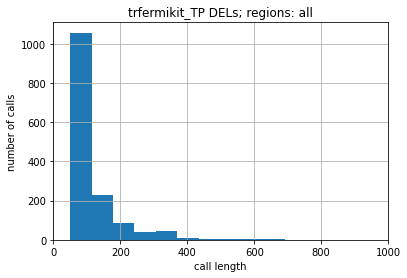

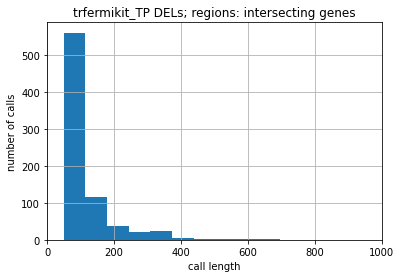

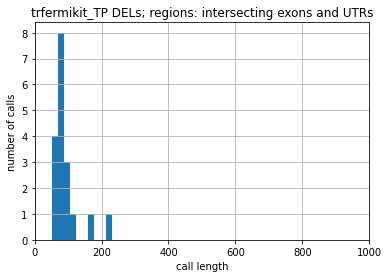

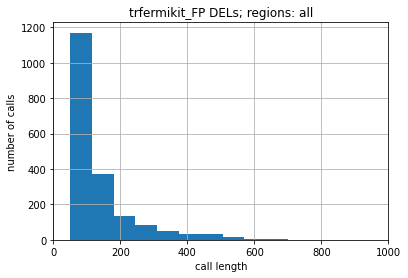

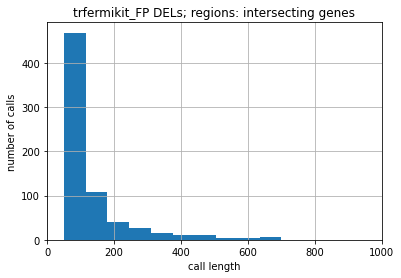

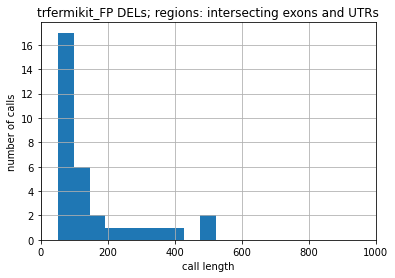

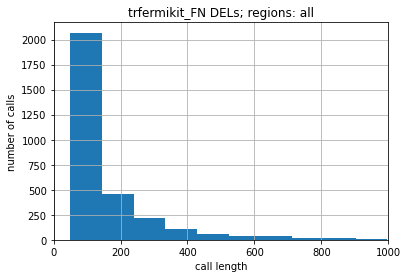

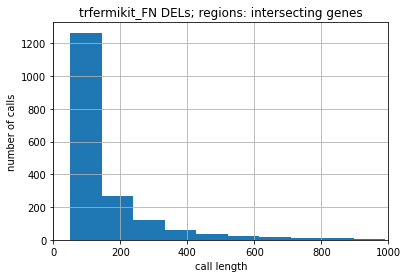

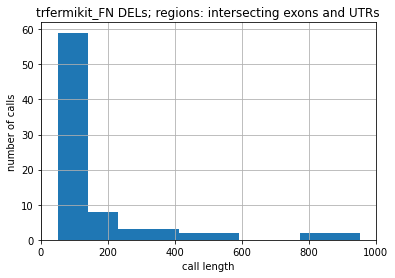

In [11]:
import pandas as pd

def plot_sv_lengths(svtype, calls_name): 
    sv_length_cutoff = 1000
    for regions in ['all', 'intersecting genes', 'intersecting exons and UTRs']:
        df = pd.read_csv('sv_lengths/sv_lengths.{}.{}.{}.csv'.format(
            get_regions_tag(regions),
            svtype,
            calls_name
        ), names=['{} {}s; regions: {}'.format(calls_name, svtype, regions)])
        df = df[df < sv_length_cutoff]
        axes = df.hist()
        axes[0][0].set_xlim((0,sv_length_cutoff))
        axes[0][0].set_xlabel('call length')
        axes[0][0].set_ylabel('number of calls')
        
def plot_sv_lengths_all(svtype): 
    plot_sv_lengths(svtype, 'trfermikit_TP')
    plot_sv_lengths(svtype, 'trfermikit_FP')
    plot_sv_lengths(svtype, 'trfermikit_FN')    
    
plot_sv_lengths_all('DEL')

## Coverage not lower over calls when regions are restricted to exons and UTRs

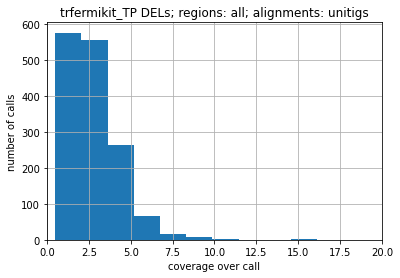

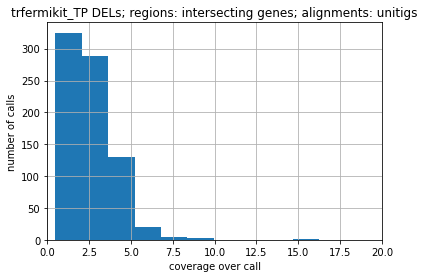

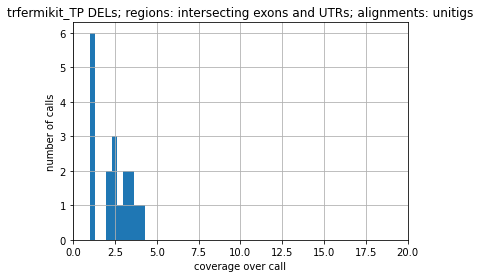

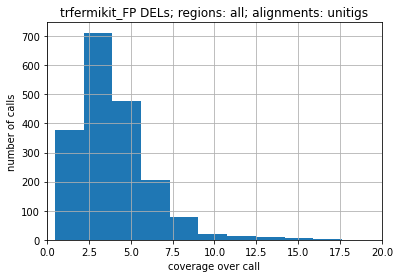

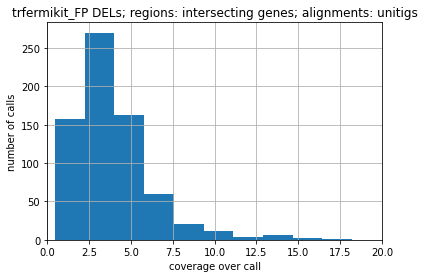

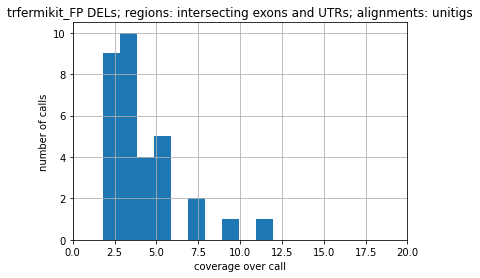

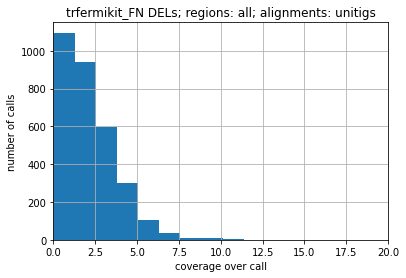

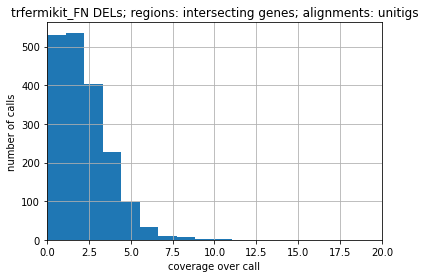

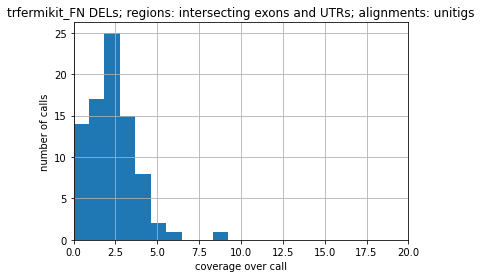

In [12]:
import pandas as pd

def plot_sv_coverages(svtype, alignments_name, calls_name, coverage_cutoff): 
    for regions in ['all', 'intersecting genes', 'intersecting exons and UTRs']:
        job = 'sv_coverages.{}.{}.{}.{}'.format(
            alignments_name,
            get_regions_tag(regions),
            svtype,
            calls_name
        )
        df = pd.read_csv('sv_coverages/{}/{}.csv'.format(job, job), names=[
            'chr', 
            'start', 
            'end',
            'coverage'
        ])
        df = df['coverage'][df['coverage'] < coverage_cutoff]        
        import matplotlib.pyplot as plt
        axes = df.hist()
        axes.set_xlim((0, coverage_cutoff))        
        axes.set_xlabel('coverage over call')
        axes.set_ylabel('number of calls')
        plt.title(
            '{} {}s; regions: {}; alignments: {}'.format(calls_name, svtype, regions, alignments_name)
        )
        plt.show()
        
def plot_sv_coverages_all(svtype, alignments_name, coverage_cutoff): 
    plot_sv_coverages(svtype, alignments_name, 'trfermikit_TP', coverage_cutoff)
    plot_sv_coverages(svtype, alignments_name, 'trfermikit_FP', coverage_cutoff)
    plot_sv_coverages(svtype, alignments_name, 'trfermikit_FN', coverage_cutoff)    
    
plot_sv_coverages_all('DEL', 'unitigs', 20)

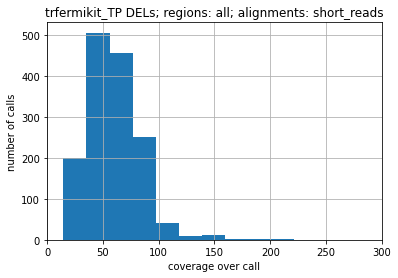

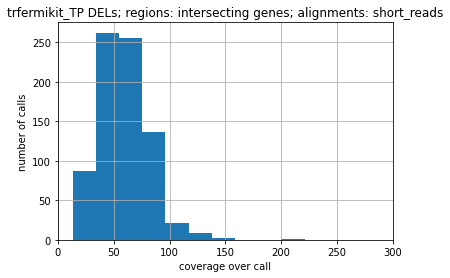

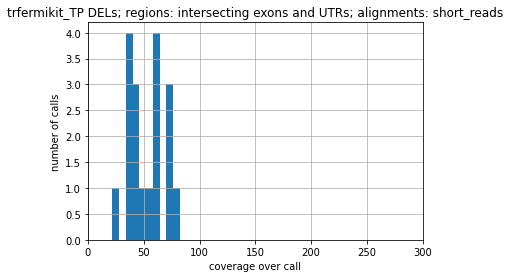

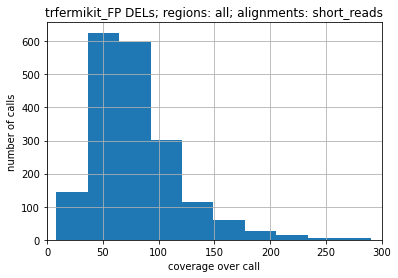

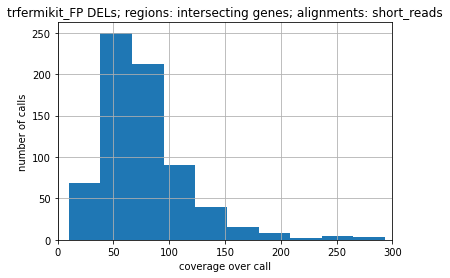

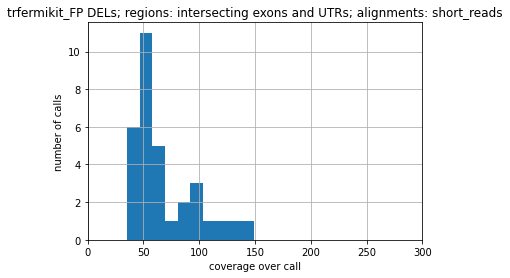

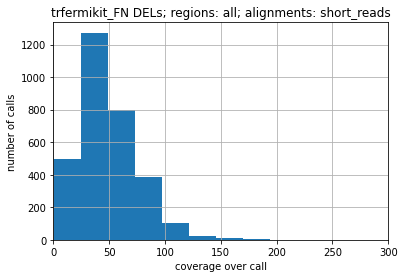

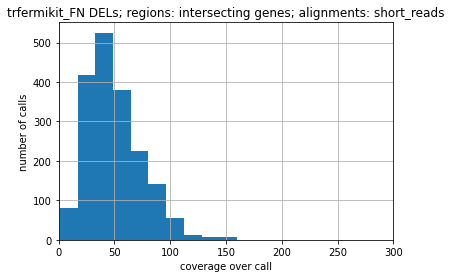

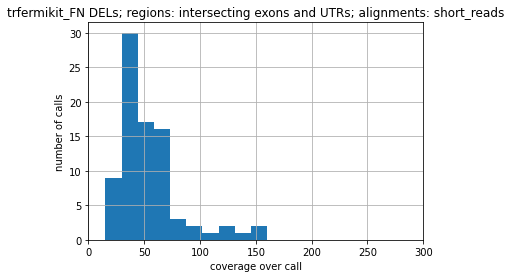

In [13]:
plot_sv_coverages_all('DEL', 'short_reads', 300)